# Week 4 Assignment

This week's assignment is to test a logistic regression model.

## Data Management

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

# bug fix for display formats to avoid run time errors
pd.set_option('display.float_format', lambda x:'%.2f'%x)

df = pd.read_csv('gapminder.csv')

# convert to numeric format
df['incomeperperson'] = pd.to_numeric(df['incomeperperson'], errors='coerce')
df['polityscore'] = pd.to_numeric(df['polityscore'], errors='coerce')
df['urbanrate'] = pd.to_numeric(df['urbanrate'], errors='coerce')

# listwise deletion of missing values
subset = df[['incomeperperson', 'polityscore', 'urbanrate']].dropna()

E:\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Convert Polity Score

Since there are 21 polity score categories I chose to compress them into the 5 categories specified by the Polity IV project author's.

E:\Anaconda2\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


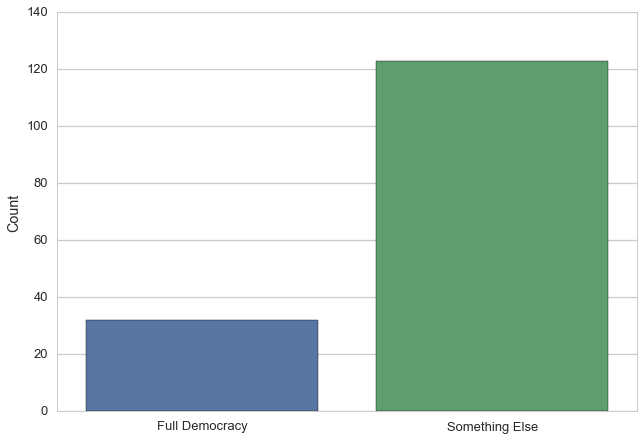

In [2]:
# This function converts the polity score to a category
def convert_polityscore_to_category(score):
    #if score == 10:
    #    return('1-Full Democracy')
    #elif score > 5:
    #    return('2-Democracy')
    #elif score > 0:
    #    return ('3-Open Anocracy')
    #elif score > -6:
    #    return ('4-Closed Anocracy')
    #else:
    #    return('5-Autocracy')
    if score == 10:
        return('Full Democracy')
    else:
        return('Something Else')

# Now we can use the function to create the new variable
subset['SocietyType'] = subset['polityscore'].apply(convert_polityscore_to_category)
subset['SocietyType'] = subset['SocietyType'].astype('category')

# Create bar chart
sns.countplot(x='SocietyType', data=subset)
plt.ylabel('Count')
plt.xlabel('')

### Create Higher than Average Income Binary Variable

Since I am doing a logistic regression I need to bin up the income variable into two categories.  I have decided to use the mean as the threshold.

In [3]:
# Set binary flag that income per person is greater than the mean
avg_income = np.mean(subset['incomeperperson'])
def higher_than_average_income(income):
    if income > avg_income:
        return 1
    else:
        return 0

subset['higher_than_average_income'] = subset['incomeperperson'].apply(higher_than_average_income)

In [4]:
counts = subset.groupby('higher_than_average_income').size()
print(counts)

higher_than_average_income
0    116
1     39
dtype: int64


## Logistic Regression Model

Now I will create a simple logistic regression model that will test the relationship between being in a higher than average income class and the type of society.

In [5]:
# logistic regression with society type
lreg1 = smf.logit(formula = 'higher_than_average_income ~ C(SocietyType)', data = subset).fit()
print (lreg1.summary())

Optimization terminated successfully.
         Current function value: 0.389711
         Iterations 6
                               Logit Regression Results                               
Dep. Variable:     higher_than_average_income   No. Observations:                  155
Model:                                  Logit   Df Residuals:                      153
Method:                                   MLE   Df Model:                            1
Date:                        Fri, 18 Dec 2015   Pseudo R-squ.:                  0.3091
Time:                                14:41:29   Log-Likelihood:                -60.405
converged:                               True   LL-Null:                       -87.436
                                                LLR p-value:                 1.944e-13
                                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------


In [6]:
# odd ratios with 95% confidence intervals
params = lreg1.params
conf = lreg1.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print (np.exp(conf))

                                  Lower CI  Upper CI   OR
Intercept                             1.54      8.26 3.57
C(SocietyType)[T.Something Else]      0.01      0.10 0.04


### Is Urban Rate a Confounder?

In [7]:
# logistic regression with society type and urbanization rate
lreg2 = smf.logit(formula = 'higher_than_average_income ~ C(SocietyType) + urbanrate', data = subset).fit()
print (lreg2.summary())

Optimization terminated successfully.
         Current function value: 0.283642
         Iterations 8
                               Logit Regression Results                               
Dep. Variable:     higher_than_average_income   No. Observations:                  155
Model:                                  Logit   Df Residuals:                      152
Method:                                   MLE   Df Model:                            2
Date:                        Fri, 18 Dec 2015   Pseudo R-squ.:                  0.4972
Time:                                14:41:30   Log-Likelihood:                -43.965
converged:                               True   LL-Null:                       -87.436
                                                LLR p-value:                 1.321e-19
                                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------


In [8]:
# odd ratios with 95% confidence intervals
params = lreg2.params
conf = lreg2.conf_int()
conf['OR'] = params
conf.columns = ['Lower CI', 'Upper CI', 'OR']
print (np.exp(conf))

                                  Lower CI  Upper CI   OR
Intercept                             0.00      0.18 0.01
C(SocietyType)[T.Something Else]      0.01      0.15 0.04
urbanrate                             1.05      1.13 1.09
